### 1. Problem Statement:

This project aims to  identify the probable cause of cancers in terms of genes responsible for different types of cancers, such as breast cancer, renal cancer, colon cancer, lung cancer, and prostate cancer. This would lead us to early identification of each type of cancer reducing the fatality rate.

#### Dataset Details:
The input dataset contains 801 samples for the corresponding 801 people who have been detected with different types of cancer. Each sample contains expression values of more than 20K genes. Samples have one of the types of tumors: 
* BRCA (Breast cancer)
* KIRC (Kidney renal clear cell carcinoma)
* COAD (Colon adenocarcinoma)
* LUAD (Lung adenocarcinoma)
* PRAD (Prostate adenocarcinoma)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

### 2. Data Extraction

In [2]:
label = pd.read_csv('Dataset/labels.csv')
data = pd.read_csv('Dataset/data.csv')

In [3]:
label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  801 non-null    object
 1   Class       801 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


*This dataset is quite large with over 20K columns, so it would be useful to  slice and filter through the dataframe to create smaller more manageable set.*

In [5]:
# Merge both the datasets.
df = pd.merge(label,data)
df.head()

Unnamed: 0 Class  gene_0    gene_1    gene_2    gene_3     gene_4  gene_5  \
0   sample_0  PRAD     0.0  2.017209  3.265527  5.478487  10.431999     0.0   
1   sample_1  LUAD     0.0  0.592732  1.588421  7.586157   9.623011     0.0   
2   sample_2  PRAD     0.0  3.511759  4.327199  6.881787   9.870730     0.0   
3   sample_3  PRAD     0.0  3.663618  4.507649  6.659068  10.196184     0.0   
4   sample_4  BRCA     0.0  2.655741  2.821547  6.539454   9.738265     0.0   

     gene_6    gene_7  ...  gene_20521  gene_20522  gene_20523  gene_20524  \
0  7.175175  0.591871  ...    4.926711    8.210257    9.723516    7.220030   
1  6.816049  0.000000  ...    4.593372    7.323865    9.740931    6.256586   
2  6.972130  0.452595  ...    5.125213    8.127123   10.908640    5.401607   
3  7.843375  0.434882  ...    6.076566    8.792959   10.141520    8.942805   
4  6.566967  0.360982  ...    5.996032    8.891425   10.373790    7.181162   

   gene_20525  gene_20526  gene_20527  gene_20528  gene_20529  gene_20530  
0    9.119813   12.003135    9.650743    8.921326    5.286759         0.0  
1    8.381612   12.674552   10.517059    9.397854    2.094168         0.0  
2    9.911597    9.045255    9.788359   10.090470    1.683023         0.0  
3    9.601208   11.392682    9.694814    9.684365    3.292001         0.0  
4    9.846910   11.922439    9.217749    9.461191    5.110372         0.0  

[5 rows x 20533 columns]

In [6]:
# drop the column "Unnamed: 0"
df = df.drop(['Unnamed: 0'], axis=1)

In [7]:
# Checking the number of NAs by row and by columns
print('Number of rows with any NA : {0:5d} \nNumber of cols with any NA : {1:5d}'
      .format(df.loc[df.isnull().any(axis=1),:].shape[0], df.loc[:,df.isnull().any(axis=0)].shape[1]))

Number of rows with any NA :     0 
Number of cols with any NA :     0


*It looks like there is no NAs in gene sequence data. But there seems a number of 0 values on some specific genes (i.e., gene_5, gene_8).*

In [8]:
# Checking the number of row and and columns that have all zero values
print('Number of rows with all Zero values : {0:5d} \nNumber of cols with all Zero values : {1:5d}'
      .format(df.loc[df.isin([0]).all(axis=1),:].shape[0], df.loc[:,df.isin([0]).all(axis=0)].shape[1]))

Number of rows with all Zero values :     0 
Number of cols with all Zero values :   267


*There are 267 genes (columns) that have 0 value for all the samples and we will drop these genes from the data.*

In [9]:
df = df.drop(columns = df.loc[:,df.isin([0]).all(axis=0)].columns)

### 3. Exploratory Data Analysis

In [23]:
# check data balance
df['Class'].value_counts()

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64

*There are 3/8 of samples with BRCA (breast cancer). The number of samples of KIRC, LUAD and PRAD are quite similar. COAD has the lowest precentage.*

In [10]:
# describe will give some statistical values
df.describe()

gene_0      gene_1      gene_2      gene_3      gene_4      gene_6  \
count  801.000000  801.000000  801.000000  801.000000  801.000000  801.000000   
mean     0.026642    3.010909    3.095350    6.722305    9.813612    7.405509   
std      0.136850    1.200828    1.065601    0.638819    0.506537    1.108237   
min      0.000000    0.000000    0.000000    5.009284    8.435999    3.930747   
25%      0.000000    2.299039    2.390365    6.303346    9.464466    6.676042   
50%      0.000000    3.143687    3.127006    6.655893    9.791599    7.450114   
75%      0.000000    3.883484    3.802534    7.038447   10.142324    8.121984   
max      1.482332    6.237034    6.063484   10.129528   11.355621   10.718190   

           gene_7      gene_8      gene_9     gene_10  ...  gene_20521  \
count  801.000000  801.000000  801.000000  801.000000  ...  801.000000   
mean     0.499882    0.016744    0.013428    0.688177  ...    5.896573   
std      0.508799    0.133635    0.204722    1.173568  ...    0.746399   
min      0.000000    0.000000    0.000000    0.000000  ...    2.853517   
25%      0.000000    0.000000    0.000000    0.000000  ...    5.454926   
50%      0.443076    0.000000    0.000000    0.360196  ...    5.972582   
75%      0.789354    0.000000    0.000000    0.903887  ...    6.411292   
max      2.779008    1.785592    4.067604   12.293023  ...    7.771054   

       gene_20522  gene_20523  gene_20524  gene_20525  gene_20526  gene_20527  \
count  801.000000  801.000000  801.000000  801.000000  801.000000  801.000000   
mean     8.765891   10.056252    4.847727    9.741987   11.742228   10.155271   
std      0.603176    0.379278    2.382728    0.533898    0.670371    0.580569   
min      6.678368    8.669456    0.000000    7.974942    9.045255    7.530141   
25%      8.383834    9.826027    3.130750    9.400747   11.315857    9.836525   
50%      8.784144   10.066385    5.444935    9.784524   11.749802   10.191207   
75%      9.147136   10.299025    6.637412   10.082269   12.177852   10.578561   
max     11.105431   11.318243    9.207495   11.811632   13.715361   11.675653   

       gene_20528  gene_20529  gene_20530  
count  801.000000  801.000000  801.000000  
mean     9.590726    5.528177    0.095411  
std      0.563849    2.073859    0.364529  
min      7.864533    0.593975    0.000000  
25%      9.244219    4.092385    0.000000  
50%      9.566511    5.218618    0.000000  
75%      9.917888    6.876382    0.000000  
max     12.813320   11.205836    5.254133  

[8 rows x 20264 columns]

*We can see the general descriptive statistics and summary of the genes dataframe for the different samples. The scales of gene expression values are between 0 to 10.*

In [12]:
data_gene_mean_byClass = df.groupby(['Class']).agg('mean')
data_gene_std_byClass = df.groupby(['Class']).agg(np.std)
data_gene_min_byClass = df.groupby(['Class']).agg('min')
data_gene_max_byClass = df.groupby(['Class']).agg('max')
data_gene_q25_byClass = df.groupby(['Class']).quantile(0.25)
data_gene_q75_byClass = df.groupby(['Class']).quantile(0.75)
data_gene_q90_byClass = df.groupby(['Class']).quantile(0.90)

In [13]:
# A dataframe for the overall average of each cancer type
pd.concat([
    data_gene_mean_byClass.loc['BRCA', ].describe(),
    data_gene_mean_byClass.loc['COAD', ].describe(),
    data_gene_mean_byClass.loc['KIRC', ].describe(),
    data_gene_mean_byClass.loc['LUAD', ].describe(),
    data_gene_mean_byClass.loc['PRAD', ].describe()
    ], axis=1
         )

BRCA          COAD          KIRC          LUAD          PRAD
count  20264.000000  20264.000000  20264.000000  20264.000000  20264.000000
mean       6.498631      6.378103      6.563778      6.615298      6.551134
std        3.873167      3.960270      3.894867      3.810488      3.885593
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        2.935878      2.594280      3.002766      3.295457      3.079487
50%        7.635416      7.452971      7.728283      7.716860      7.614194
75%        9.622623      9.645680      9.666443      9.637154      9.666683
max       16.526564     16.783892     16.780866     16.767862     18.237407

*We can also see the statistics for each cancer type. For example, we can see that the mean values of all the genes are around 6.4 among all cancer types.*

In [14]:
# Plot the merged dataset as a hierarchically-clustered heatmap.
heatmap_data = pd.pivot_table(df, index=['Class'])                            
heatmap_data

gene_0    gene_1   gene_10   gene_100  gene_1000  gene_10000  \
Class                                                                   
BRCA   0.011362  2.839739  0.544066  10.681488  10.303568    3.258028   
COAD   0.022212  3.438381  0.357278  11.015745   9.951124    3.462039   
KIRC   0.046544  2.398129  1.166824  10.238999  11.148094    1.651798   
LUAD   0.041088  3.358260  0.607541  10.517670  10.503698    3.754181   
PRAD   0.026544  3.441041  0.765608  10.282936   9.967433    1.949878   

       gene_10001  gene_10002  gene_10003  gene_10004  ...  gene_9990  \
Class                                                  ...              
BRCA     7.339461    7.900497    7.489146    7.508378  ...   1.969278   
COAD     5.526673    7.487396    3.783493    6.959238  ...   2.216178   
KIRC     6.895752    7.686932    7.269611    7.636246  ...   1.824964   
LUAD     7.281878    7.041924    6.145042    7.148682  ...   2.609490   
PRAD     7.946141    8.529695    5.696368    7.396572  ...   1.623491   

       gene_9991  gene_9992  gene_9993  gene_9994  gene_9995  gene_9996  \
Class                                                                     
BRCA    5.142237   1.736160   2.312551   1.696127   2.493789   0.046527   
COAD    0.354828   1.833606   1.619692   3.839205   2.396207   0.090327   
KIRC    0.596508   2.393303   1.872888   1.289448   3.139623   0.130416   
LUAD    2.801700   2.738326   1.869805   2.217144   2.459608   0.042070   
PRAD    4.594215   1.684084   2.588050   1.703772   3.568490   0.572893   

       gene_9997  gene_9998  gene_9999  
Class                                   
BRCA    2.099709   0.151063   6.954733  
COAD    2.298246   0.065007   6.618466  
KIRC    2.387948   0.148641   6.429343  
LUAD    2.281828   0.056608   6.721517  
PRAD    3.621548   0.094953   7.104225  

[5 rows x 20264 columns]

*We created a pivot table which takes Class as index and aggrates values by taking the mean of each gene for each cancer type.*

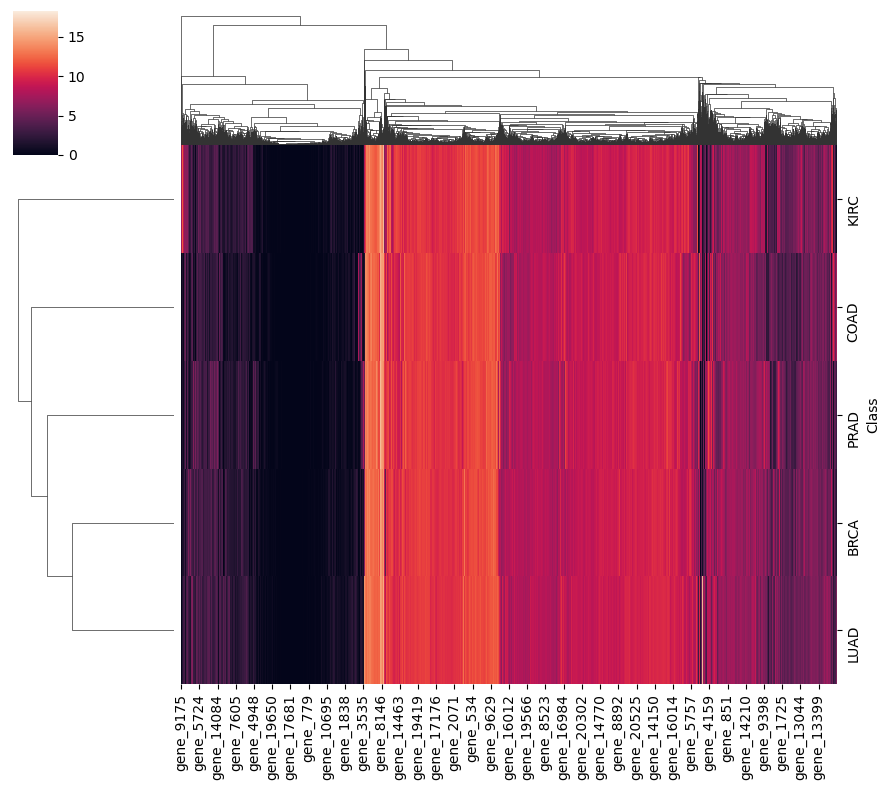

In [15]:
sns.clustermap(heatmap_data, figsize=(9,8))

*A hierarchically-clustered heatmap uses a hierarchical clusters to order data by similarity. This reorganizes the data for the rows and columns and displays similar content next to one another for even more depth of understanding the data. For most of genes, they have very similar mean values across different cancer types. This may be simply because some genes have low gene expression count in general, such as gene19650 and gen_779 and some have high gene expression count such as gene_14463 and gene_534. But for other genes such as gene_4159 and gen_1725, the means are quite different among cancer types. Based on the clustering among cancer types, it shows that the genes between LUAD (Lung adenocarcinoma) and BRCA (breast cancer) are mostly similar.* 

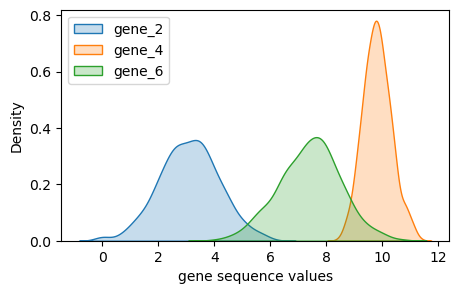

In [16]:
# selecting genes (2,4,6) and plotting them in the same figure
cols = ['gene_2', 'gene_4', 'gene_6']
plt.figure(figsize=(5,3))

for col in cols:
    sns.kdeplot(df[col], shade=True, legend=True)

plt.legend(cols,loc='upper left')
plt.xlabel('gene sequence values')
plt.show()

*It can be seen that gene_6 and gene_2 center around different values, ~3 and ~8 respectively, with very similar distributions. Gene_4 on the other hand, shows a much different distribution and higher mean than the other two.*

*Sometimes it would be interesting to see how the gene sequence shows in the samples. For example, show sample_9's gene values in a scatter plot.*

In [17]:
df1 = data.T
dt_new_header = df1.iloc[0] #grab the first row for the header
df1 = df1[1:] #take the data less the header row
df1.columns = dt_new_header #set the header row as the df header
df1.head()

Unnamed: 0   sample_0  sample_1  sample_2   sample_3  sample_4  sample_5  \
gene_0            0.0       0.0       0.0        0.0       0.0       0.0   
gene_1       2.017209  0.592732  3.511759   3.663618  2.655741  3.467853   
gene_2       3.265527  1.588421  4.327199   4.507649  2.821547  3.581918   
gene_3       5.478487  7.586157  6.881787   6.659068  6.539454  6.620243   
gene_4      10.431999  9.623011   9.87073  10.196184  9.738265  9.706829   

Unnamed: 0  sample_6  sample_7   sample_8  sample_9  ... sample_791  \
gene_0           0.0       0.0        0.0       0.0  ...        0.0   
gene_1      1.224966  2.854853   3.992125  3.642494  ...   3.080061   
gene_2      1.691177  1.750478    2.77273  4.423558  ...   2.815739   
gene_3      6.572007   7.22672   6.546692  6.849511  ...   6.209617   
gene_4      9.640511  9.758691  10.488252  9.464466  ...   9.644469   

Unnamed: 0 sample_792 sample_793 sample_794 sample_795 sample_796 sample_797  \
gene_0            0.0        0.0        0.0   0.436588        0.0        0.0   
gene_1       4.337404   2.068224   4.288388   4.472176   1.865642   3.942955   
gene_2       2.597126   0.857663    3.45249   4.908746   2.718197   4.453807   
gene_3       6.070379   6.218739   7.209151   5.937848   7.350099   6.346597   
gene_4        9.86399  10.623068    9.87562   9.330901  10.006003  10.056868   

Unnamed: 0 sample_798 sample_799 sample_800  
gene_0            0.0        0.0        0.0  
gene_1       3.249582   2.590339   2.325242  
gene_2       3.707492   2.787976   3.805932  
gene_3       8.185901   7.318624   6.530246  
gene_4       9.504082   9.987136   9.560367  

[5 rows x 801 columns]

In [18]:
# getting the index number which in this case also coinsides with gene number
df1.reset_index(inplace=True)
df1['gene'] = df1.index # adds new column gene at the end of the dataframe

df1.head()

Unnamed: 0   index   sample_0  sample_1  sample_2   sample_3  sample_4  \
0           gene_0        0.0       0.0       0.0        0.0       0.0   
1           gene_1   2.017209  0.592732  3.511759   3.663618  2.655741   
2           gene_2   3.265527  1.588421  4.327199   4.507649  2.821547   
3           gene_3   5.478487  7.586157  6.881787   6.659068  6.539454   
4           gene_4  10.431999  9.623011   9.87073  10.196184  9.738265   

Unnamed: 0  sample_5  sample_6  sample_7   sample_8  ... sample_792  \
0                0.0       0.0       0.0        0.0  ...        0.0   
1           3.467853  1.224966  2.854853   3.992125  ...   4.337404   
2           3.581918  1.691177  1.750478    2.77273  ...   2.597126   
3           6.620243  6.572007   7.22672   6.546692  ...   6.070379   
4           9.706829  9.640511  9.758691  10.488252  ...    9.86399   

Unnamed: 0 sample_793 sample_794 sample_795 sample_796 sample_797 sample_798  \
0                 0.0        0.0   0.436588        0.0        0.0        0.0   
1            2.068224   4.288388   4.472176   1.865642   3.942955   3.249582   
2            0.857663    3.45249   4.908746   2.718197   4.453807   3.707492   
3            6.218739   7.209151   5.937848   7.350099   6.346597   8.185901   
4           10.623068    9.87562   9.330901  10.006003  10.056868   9.504082   

Unnamed: 0 sample_799 sample_800 gene  
0                 0.0        0.0    0  
1            2.590339   2.325242    1  
2            2.787976   3.805932    2  
3            7.318624   6.530246    3  
4            9.987136   9.560367    4  

[5 rows x 803 columns]

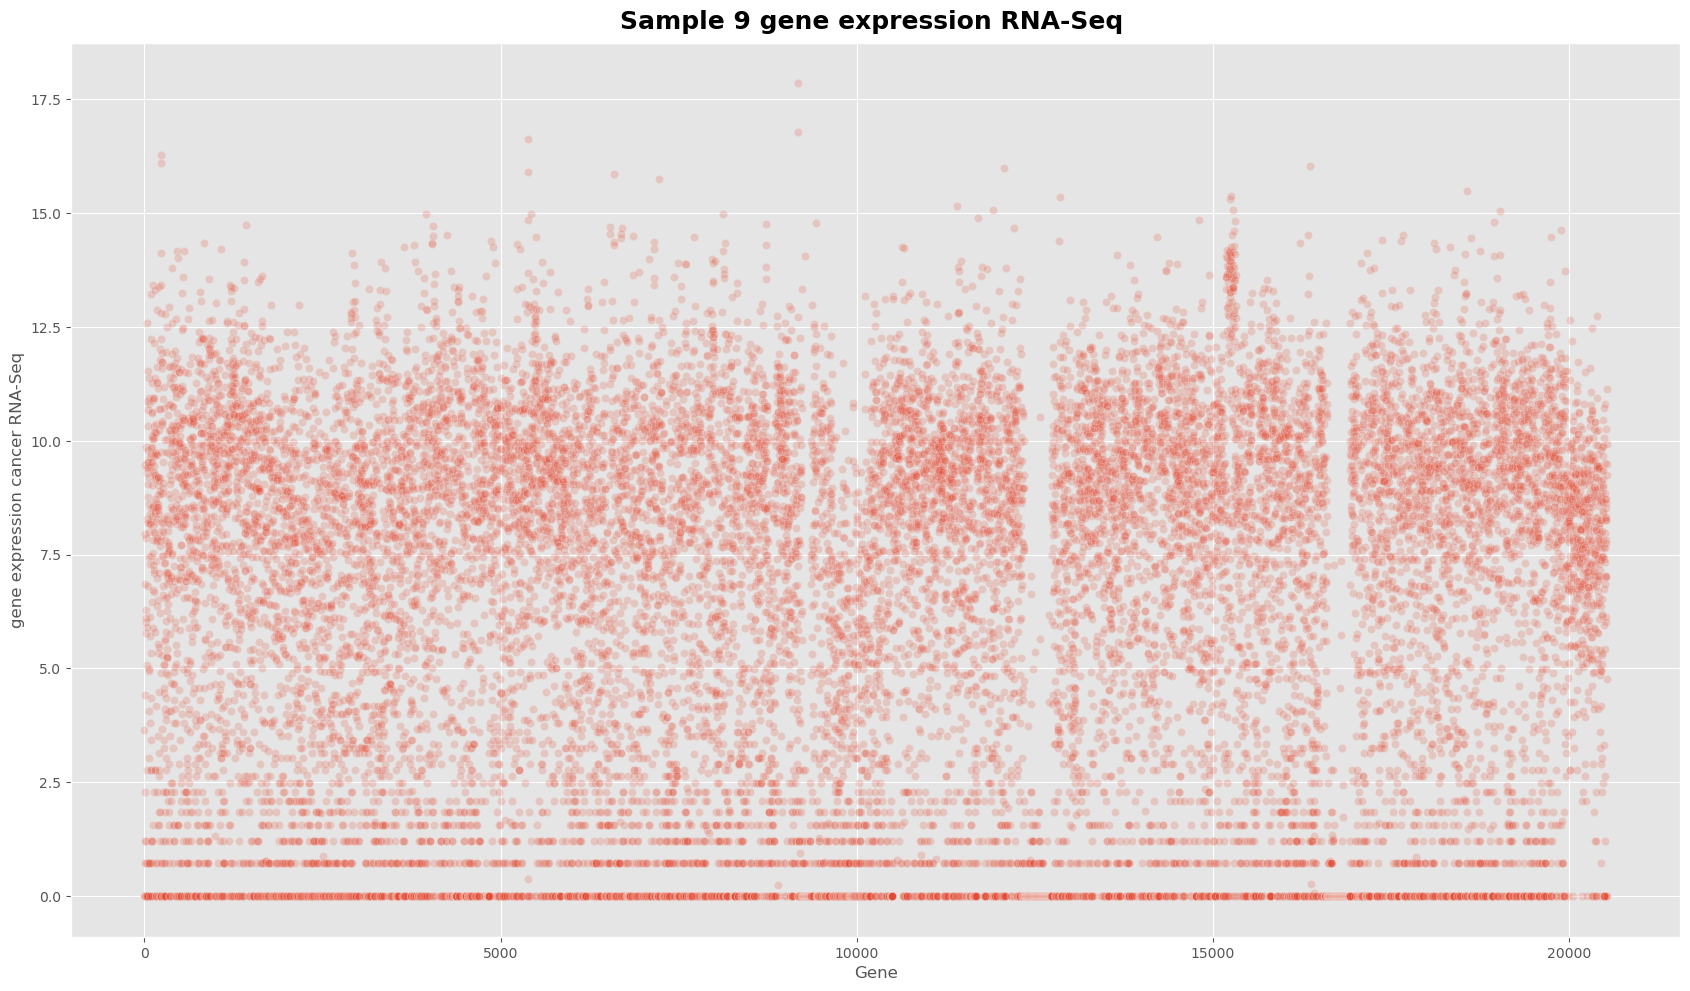

In [19]:
# setting up the plot style
plt.style.use('ggplot')

fig_dims = (17, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(ax=ax, y="sample_9", x='gene', data=df1,
               alpha=.2)

# make adjustments
ax.set_ylabel('gene expression cancer RNA-Seq')
ax.set_xlabel('Gene')

ax.text(x=0.5, y=1.01, s='Sample 9 gene expression RNA-Seq ', fontsize=18, 
        weight='bold', ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout()
plt.show()

*Next we can see how the different samples compare for each cancer type.*

In [20]:
# add Sample column
df2 = df.copy()
df2['Sample'] = df2.index
data_melt = df2.melt(id_vars=['Class','Sample'])
data_melt.head()

Class  Sample variable  value
0  PRAD       0   gene_0    0.0
1  LUAD       1   gene_0    0.0
2  PRAD       2   gene_0    0.0
3  PRAD       3   gene_0    0.0
4  BRCA       4   gene_0    0.0

*We got a dataframe using melt() function, which uses ['Class', Sample'] as a new index and converts the column headers into row values of a new variable columns and all the values from those columns get placed into respective row values of a value column.*

In [21]:
data_melt['variable'] = data_melt['variable'].map(lambda x: x.lstrip('gene_'))
data_melt.rename(columns={"variable": "Gene"}, inplace=True)
data_melt.head()

Class  Sample Gene  value
0  PRAD       0    0    0.0
1  LUAD       1    0    0.0
2  PRAD       2    0    0.0
3  PRAD       3    0    0.0
4  BRCA       4    0    0.0

*Then we rename variable as Gene and convert the values in Gene column as integer.*

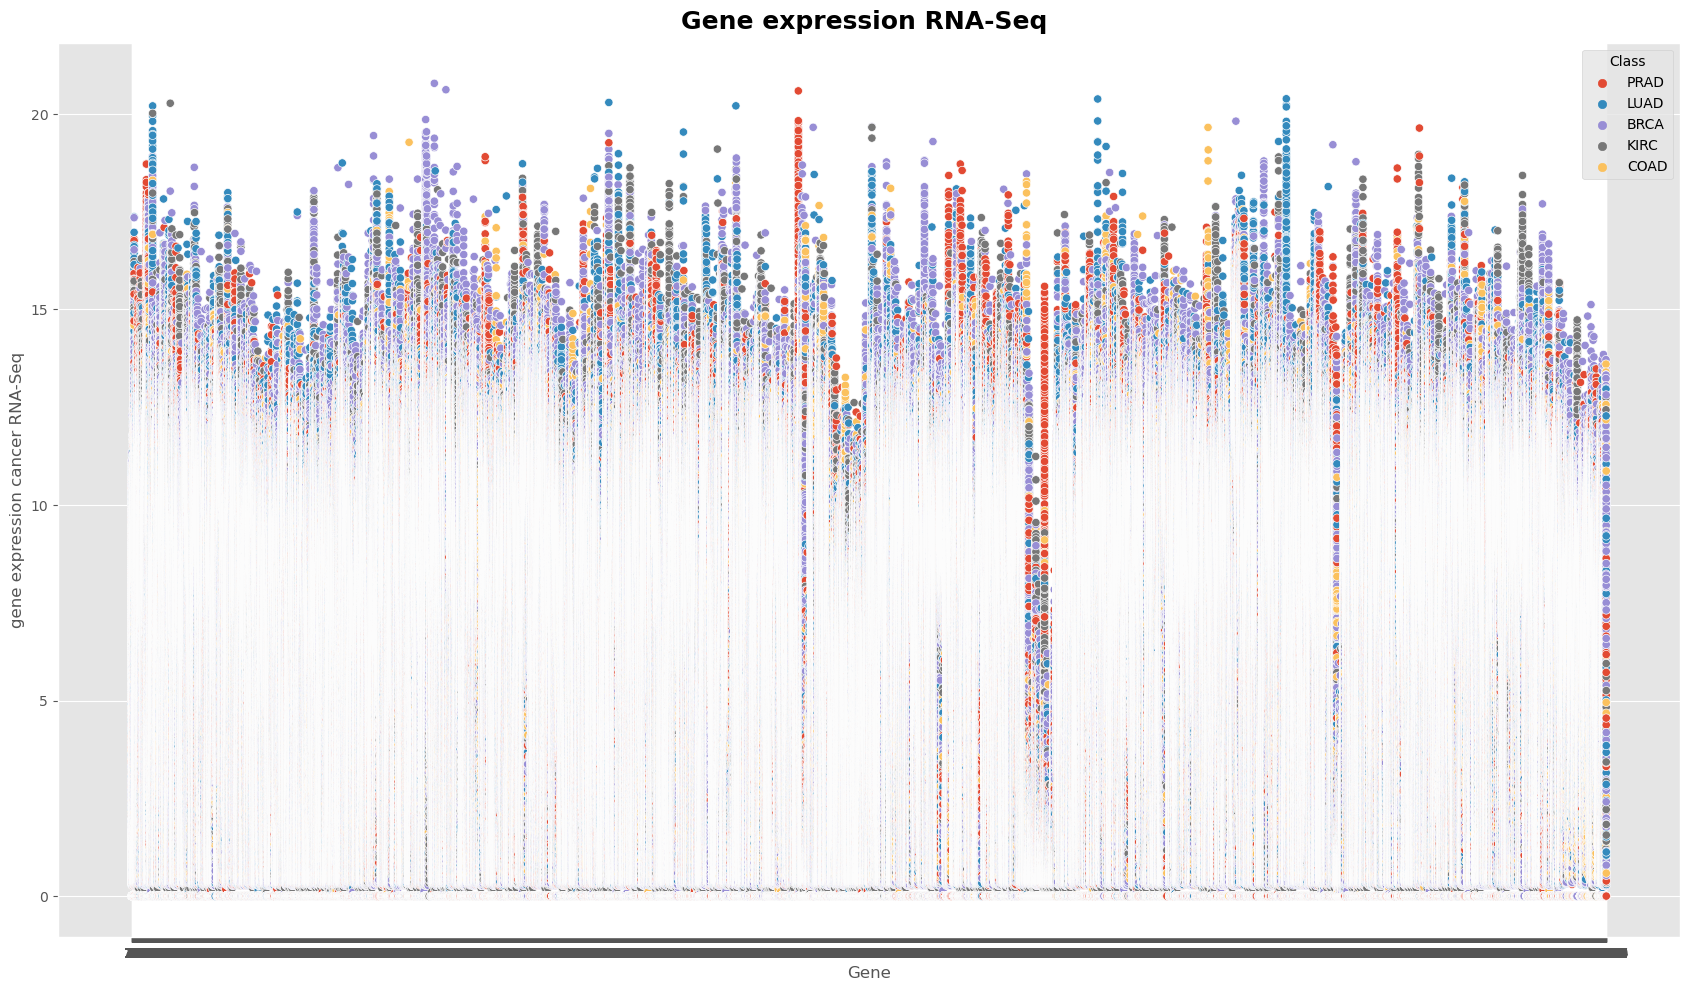

In [22]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.scatterplot(ax=ax,data=data_melt, x="Gene", y="value", hue="Class")

# make adjustments
ax.set_ylabel('gene expression cancer RNA-Seq')
ax.set_xlabel('Gene')

ax.text(x=0.5, y=1.01, s='Gene expression RNA-Seq ', fontsize=18, 
        weight='bold', ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout()

plt.show()

*Above is a plot of all the gene expressions over all samples Majority of gene count expression, regardless of cancer type, appears to have gene counts over _10_ counts on average, we can do some descriptive statistics to confirm this. Moreover, something interesting is how _PRAD_ cancer types (the red points), appear to have much higher counts in those lower expression genes, compared to the other cancer types. This might be an indication of either something unique about that cancer type or maybe something unique about the body tissue from which the sample is located.*

### 4 Hypothesis Testing

ANOVA is used to test if all the different genes have the same underlying mean in their count data. F statistics is calculated and compared to critical values with the hypotheses:

> $H_{0}: \delta_{i} = 0$ for all samples 'i'
>
> $H_{1}: \delta_{i} \neq 0$ for at least one sample 'i'
>
> *where $\delta_{i}$ is the difference between the mean of group **i** and the overall mean*
> 
> $\alpha = 0.05$

For us to use ANOVA, we must check the assumptions for ANOVA:
1. Independence (of samples and of observations within each sample)
    - _We already know the samples are independent_
2. Equal variances
    - _We will do a visual check to see which genes meet this assumption_
3. Large sample sizes or normal distributions
    - _We will check for each testing scenerio_

First let's select some genes and check if they have the same population mean. We have a sample size of 801 for each gene so it is large enough. We still need to check the variance.

Text(0.5, 1.0, 'Box-plot for Selected Genes')

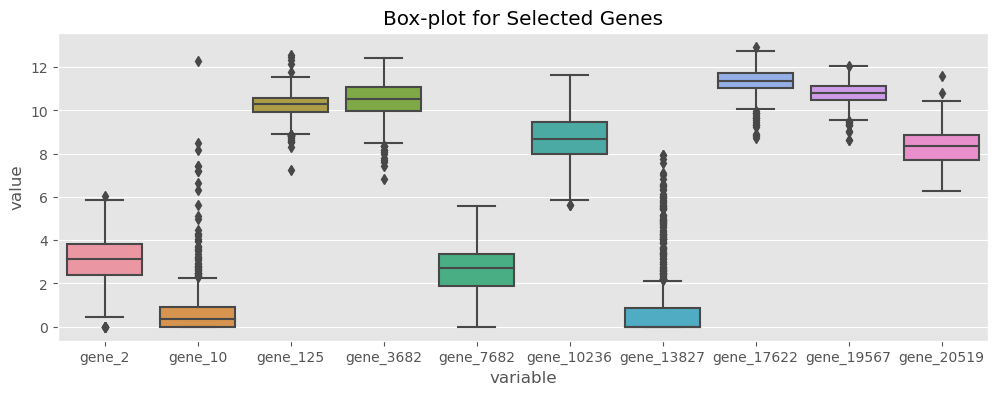

In [24]:
# Select a few genes to include in the comparison
gene_names = ['gene_2','gene_10','gene_125','gene_3682', 'gene_7682',
              'gene_10236', 'gene_13827','gene_17622','gene_19567','gene_20519']


# Check the variances through a boxplot
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x="variable", y="value", data=pd.melt(df[gene_names]), ax=ax)
plt.title('Box-plot for Selected Genes')

*We see that not all the genes appear to have equal variances, the only ones that seem close enough are gene_125, gene_17622 and gene_19567, so we'll run an ANOVA test for these.*

In [25]:
cols = ['gene_125','gene_17622','gene_19567']

# Call the ANOVA function from statsmodels
stats.f_oneway(df[cols[0]],data[cols[1]],data[cols[2]])    

F_onewayResult(statistic=817.9916065233072, pvalue=1.3009739969227062e-271)

In [26]:
# Anova with statsmodels functions and function to display table
########
import statsmodels.api as sm
from statsmodels.formula.api import ols

data_anova = pd.melt(df[cols]) # data in format needed
model = ols('value ~ C(variable)', data=data_anova).fit() # 'r' like formula for anova model
aov_table = sm.stats.anova_lm(model, typ=2) # running anova 

def anova_table(aov):
    """
        The function below was created specifically for the one-way ANOVA table results returned for Type II sum of squares
    """
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)


sum_sq      df     mean_sq           F         PR(>F)  \
C(variable)  496.071105     2.0  248.035553  817.991607  1.300974e-271   
Residual     727.740140  2400.0    0.303225         NaN            NaN   

               eta_sq  omega_sq  
C(variable)  0.405349  0.404754  
Residual          NaN       NaN

*Both SciPy and statsmodels give the same values for the F statistic and p-value, but we get the added bonus with statsmodels to perform "r style" functions and a nice display. Since $p < \alpha$, We can reject the hypothesis that all of these selected genes have the same underlying mean count data.*

Next let's check if the underlying population mean of genes across different cancer types is identical. To do this, we need to check the sample size for each cancer type first.

In [27]:
df['Class'].value_counts()

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64

COAD has the least sample size which is 78, but it is large enough for conducting our test. Then we will check the equal variance.

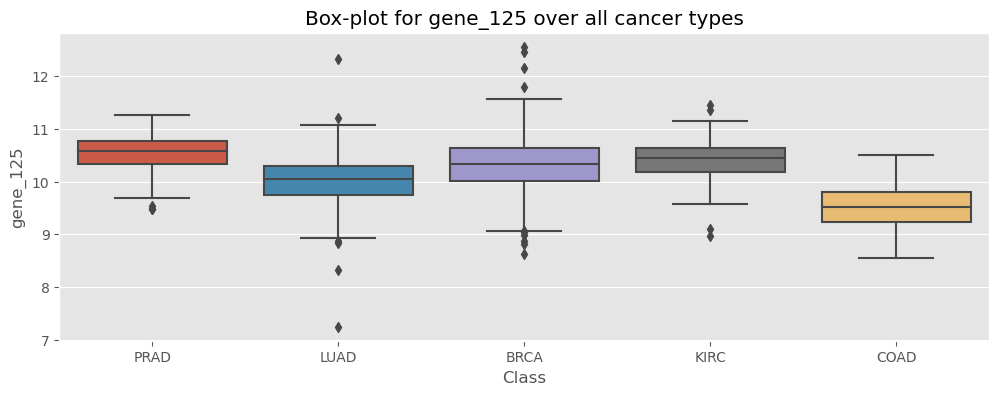

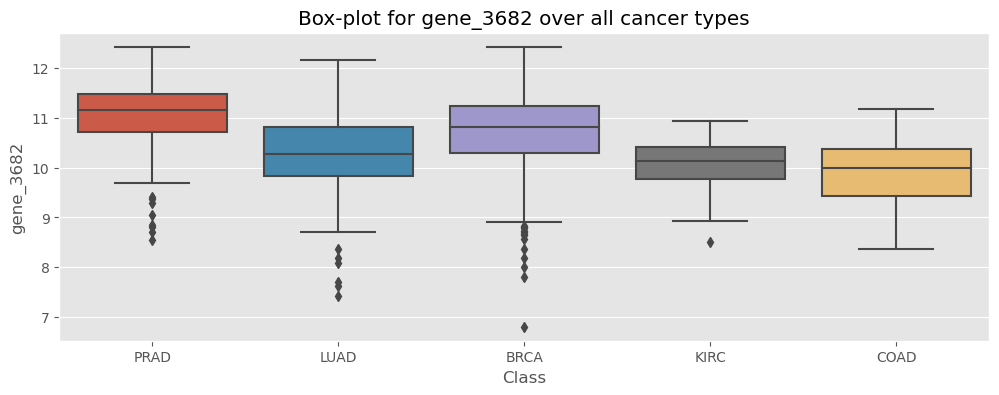

In [28]:
# Select a few genes to include in the comparison
gene_names = ['gene_125','gene_3682']

for gene in gene_names:
    # Check the variances through a boxplot
    fig_dims = (12, 4)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.boxplot(x="Class", y=gene, data=df[['Class', gene]], ax=ax)
    plt.title('Box-plot for {} over all cancer types'.format(gene))

*The variances over different cancer types can be quite different. We will conduct the Kruskal-Wallis H-test instead.*

In [29]:
def h_test(df_f_test,gene):  
    df_anova = df_f_test[[gene,'Class']]
    grps = pd.unique(df_anova.Class.values)
    d_data = {grp:df_anova[gene][df_anova.Class == grp] for grp in grps}
    F, p = stats.kruskal(d_data['LUAD'], d_data['PRAD'], d_data['BRCA'], d_data['KIRC'], d_data['COAD'])
    return p

In [30]:
genes_equal_means = []
genes_nonequal_means = []

for gene in df.columns:
    if 'gene' not in gene:
        continue
    p = h_test(df, gene)
    if p<0.05:
        genes_nonequal_means.append(gene)
    else:
        genes_equal_means.append(gene)        

In [31]:
len(genes_equal_means), len(genes_nonequal_means)

(591, 19673)

*There are 591 genes whose underlying population means are identical among all the cancer types. These genes may not have critical impact on the cancer types.*

### 5. Dimensionality Reduction

Each sample has expression values for around 20K genes. However, it may not be necessary to include all 20K genes expression values to analyze each cancer type. Therefore, we will identify a smaller set of attributes which will then be used to fit multiclass classification models. 

In [32]:
# Split input and target variables
name_to_number = {'PRAD': 0,
                  'LUAD': 1,
                  'BRCA': 2,
                  'KIRC': 3,
                  'COAD': 4}

df['Class'] = df['Class'].map(name_to_number) 

y = df['Class']
X = df.drop(columns=['Class'])

In [33]:
# Given that our gene count data is so varied in the values per each column, we'll also apply a 
# normalization technique through MinMaxScaler.

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
X_Scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns, index = X.index)

First we define some useful functions before carrying out dimensionality reduction.

In [34]:
# get a new dataframe after apply dimensionality reduction method
def get_reduced_df(method, n_components, X, y=None):
    
    if method == 'pca':
        dr = PCA(n_components=n_components, random_state=42)
    elif method == 'lda':
        dr = LDA(n_components=n_components)
    elif method == 'tsne':
        dr = TSNE(n_components=n_components, random_state=42)

    return pd.DataFrame(dr.fit_transform(X, y))

In [35]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

df_pca_with_2 = get_reduced_df('pca', 2, X_Scaled)
df_lda_with_2 = get_reduced_df('lda', 2, X_Scaled, y)
df_tsne_with_2 = get_reduced_df('tsne', 2, X_Scaled)

df_pca_with_2['Class'] = df['Class']
df_lda_with_2['Class'] = df['Class']
df_tsne_with_2['Class'] = df['Class']

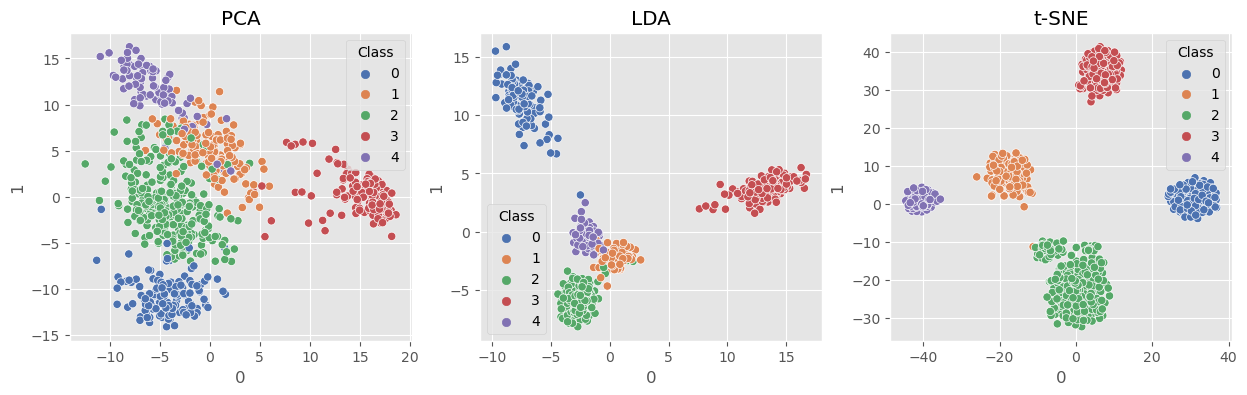

In [36]:
plt.figure(figsize = (15, 4))
plt.subplot(131)
sns.scatterplot(x=0, y=1, hue='Class', data=df_pca_with_2, palette="deep")
plt.title("PCA")
plt.subplot(132)
sns.scatterplot(x=0, y=1, hue='Class', data=df_lda_with_2, palette="deep")
plt.title("LDA")
plt.subplot(133)        
sns.scatterplot(x=0, y=1, hue='Class', data=df_tsne_with_2, palette="deep")
plt.title("t-SNE")
plt.show()

*We can see that LDA and t-SNE are capable of seperating different cancer types in two dimensions very well. PCA also did a fair job at showing a separation for the five classes.*

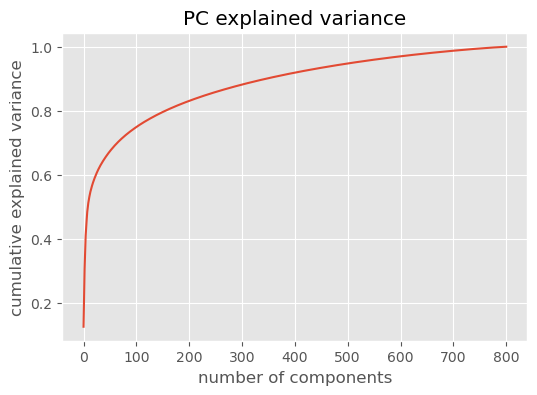

In [37]:
# doing PCA to check how many PCs are good enough to explain variance
pca = PCA().fit(X_Scaled)

# setting figure parameters for size
fig_dims = (6, 4)
fig, ax = plt.subplots(1,1,figsize=fig_dims)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PC explained variance')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

*We see that we need about 150 PCs to account for about 80% of the variance in our dataset, while keeping it in the 10s would acounts to about 40%-50%. A lower dimensionality like 2 is just easy to visualize.*

### 6. Unsupervised Learning


Our next goal is to identify groups of genes that behave similarly across samples and identify the distribution of samples corresponding to each cancer type. Therefore, this task focuses on applying various clustering techniques, e.g., K-Means, Gaussian Mixture and DBSCAN on samples.

In [38]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

In [39]:
# get the reduced dataframe in 2d using t-SNE
tsne_genes = get_reduced_df('tsne', 2, X_Scaled)

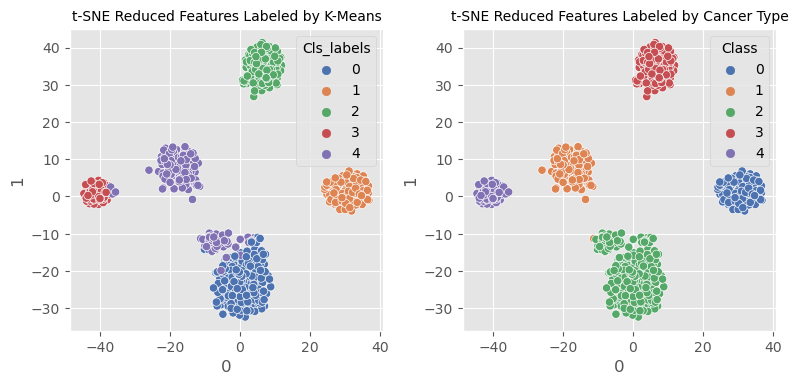

In [40]:
# Call sklearn k-means clustering for 5 clusters
kmeans = KMeans(n_clusters=5).fit(X_Scaled)

tsne_genes['Cls_labels'] = kmeans.labels_
tsne_genes['Class'] = df['Class']

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(8)

ax = fig.add_subplot(1,2,1)
ax.set_title("t-SNE Reduced Features Labeled by K-Means", fontsize=10)
sns.scatterplot(x=0, y=1, hue='Cls_labels', data=tsne_genes, palette="deep")

ax = fig.add_subplot(1,2,2)
ax.set_title("t-SNE Reduced Features Labeled by Cancer Type", fontsize=10)
sns.scatterplot(x=0, y=1, hue='Class', data=tsne_genes, palette="deep")

plt.tight_layout(pad=1)
plt.subplots_adjust(top=0.9)

plt.show()

*Class 0 and 3 are well separated from the rest. However, there are some mislabelings between class 1 and 2, and also between class 1 and 3.*

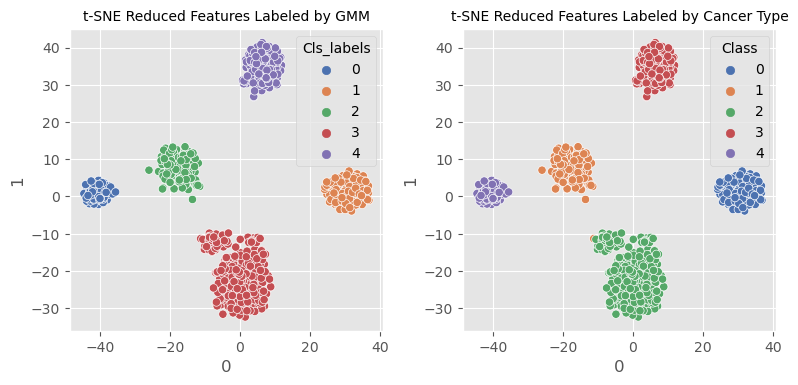

In [41]:
# Set up the GMM using scikitlearn
gmm = GaussianMixture(n_components=5).fit(tsne_genes[[0, 1]])

tsne_genes['Cls_labels'] = gmm.predict(tsne_genes[[0, 1]])

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(8)

ax = fig.add_subplot(1,2,1)
ax.set_title("t-SNE Reduced Features Labeled by GMM", fontsize=10)
sns.scatterplot(x=0, y=1, hue='Cls_labels', data=tsne_genes, palette="deep")

ax = fig.add_subplot(1,2,2)
ax.set_title("t-SNE Reduced Features Labeled by Cancer Type", fontsize=10)
sns.scatterplot(x=0, y=1, hue='Class', data=tsne_genes, palette="deep")

plt.tight_layout(pad=1)
plt.subplots_adjust(top=0.9)

plt.show()


*Guassian Mixture has done a better job in clustering the samples in the corresponding classes. All the classes are clearly separated except one sample in class 1 but close to class 2 in the reduced feature space.*

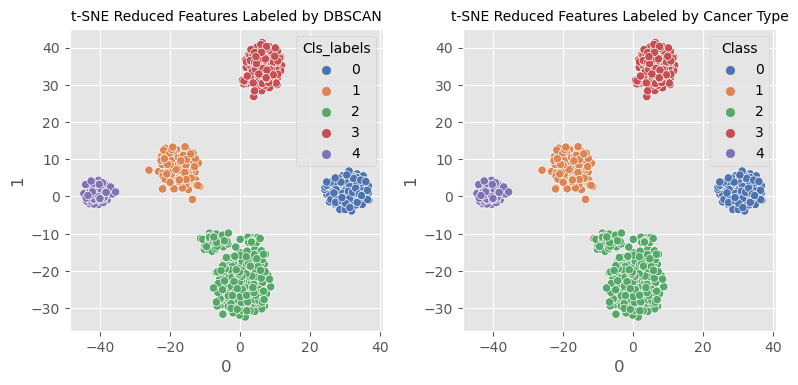

In [43]:
# Set up DBSCAN and run it on our data
dbscan = DBSCAN(eps=5, min_samples=20).fit(tsne_genes[[0, 1]])
tsne_genes['Cls_labels'] = dbscan.labels_

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(8)

ax = fig.add_subplot(1,2,1)
ax.set_title("t-SNE Reduced Features Labeled by DBSCAN", fontsize=10)
sns.scatterplot(x=0, y=1, hue='Cls_labels', data=tsne_genes, palette="deep")

ax = fig.add_subplot(1,2,2)
ax.set_title("t-SNE Reduced Features Labeled by Cancer Type", fontsize=10)
sns.scatterplot(x=0, y=1, hue='Class', data=tsne_genes, palette="deep")

plt.tight_layout(pad=1)
plt.subplots_adjust(top=0.9)

plt.show()


*Same obversation is found using DBSCAN. Only 1 sample is mislabeled. Let's verify our findings by matching the cluster labels with the known cancer types in the dataframe.*

In [44]:
# labeling
#label_class = {0: 1,  1: 0,  2: 4,  3: 3,  4: 2}

df['Cls_labels'] = dbscan.labels_
#df['Cls_labels'] = df['Cls_labels'].map(label_class)

In [45]:
# Samples of the same class (cancer type) which also correspond to the same cluster
total = 0
for cancer_type in df['Class'].unique():
    df_temp = df[ (df['Class']==cancer_type) & (df['Cls_labels']==cancer_type) ]
    print("Number of samples of class {} correspond to the same cluster: {}".format(cancer_type, len(df_temp)))
    total += len(df_temp)
print("total number of samples correspond to the same cluster: {}".format(total))

Number of samples of class 0 correspond to the same cluster: 136
Number of samples of class 1 correspond to the same cluster: 140
Number of samples of class 2 correspond to the same cluster: 300
Number of samples of class 3 correspond to the same cluster: 146
Number of samples of class 4 correspond to the same cluster: 78
total number of samples correspond to the same cluster: 800


*Identify samples identified to be belonging to another cluster but also to the same class (cancer type)*

In [46]:
total = 0
for cancer_type in df['Class'].unique():
    df_temp = df[ (df['Class']==cancer_type) & (df['Cls_labels']!=cancer_type) ]
    print("Number of samples of class {} correspond to another cluster: {}".format(cancer_type, len(df_temp)))
    print(df_temp['Cls_labels'].value_counts())
    total += len(df_temp)
print("total number of samples correspond to another cluster: {}".format(total))

Number of samples of class 0 correspond to another cluster: 0
Series([], Name: Cls_labels, dtype: int64)
Number of samples of class 1 correspond to another cluster: 1
2    1
Name: Cls_labels, dtype: int64
Number of samples of class 2 correspond to another cluster: 0
Series([], Name: Cls_labels, dtype: int64)
Number of samples of class 3 correspond to another cluster: 0
Series([], Name: Cls_labels, dtype: int64)
Number of samples of class 4 correspond to another cluster: 0
Series([], Name: Cls_labels, dtype: int64)
total number of samples correspond to another cluster: 1


*There is only 1 sample that is misclassified when using DBSCAN.*

### 7. Supervised Learning

Our final task is to build a robust classification model(s) for identifying each type of cancer.

#### 7.1 Build a classification model(s) using multiclass SVM, Random Forest, and Deep Neural Network

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Scaled,y,test_size=0.20,random_state=42)

In [48]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

import time

In [49]:
algorithms = {}
algorithms['Linear SVM'] = SVC(kernel="linear", C=0.025)
algorithms['Random Forest'] = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
algorithms['Neural Net'] = MLPClassifier(hidden_layer_sizes=20, alpha=1, max_iter=50)

In [50]:
def train(X_train, X_test, y_train, y_test):
    
    # Initialize lists
    names = []
    train_accuracy = []
    test_accuracy = []
    train_f1 = []
    test_f1 = []
    cross_validation_scores = []
    runtime = []

    # Iterate ofer each element in algorithms
    for name, clf in algorithms.items(): 
        t1 = time.time()
        names.append(name)
    
        clf.fit(X_train, y_train)
    
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        train_accuracy.append(accuracy_score(y_train, y_train_pred))
        test_accuracy.append(accuracy_score(y_test, y_test_pred))
    
        train_f1.append(f1_score(y_train, y_train_pred, average='weighted'))
        test_f1.append(f1_score(y_test, y_test_pred, average='weighted'))
    
        kfold = KFold(n_splits=5, random_state=42, shuffle=True)
        result = cross_val_score(clf, np.vstack((X_train, X_test)), 
                           np.hstack((y_train, y_test)), cv=kfold, scoring='accuracy')
    
         # print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % (name, result.mean()*100, result.std()*100))
        cross_validation_scores.append(result.round(3))
        t2 = time.time()
        runtime.append(t2-t1)
   
    # print results
    # Create comparison dataframe
    model_comparison = pd.DataFrame({'Algorithm': names,
                                 'Train accuracy': train_accuracy,
                                 'Test accuracy': test_accuracy,
                                 'Cross validation score': cross_validation_scores,
                                 'Runtime': runtime,})

    # Sort by Test_RMSE
    print(model_comparison.sort_values(by=['Test accuracy'], ascending=False))

In [51]:
train(X_train, X_test, y_train, y_test)

C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


       Algorithm  Train accuracy  Test accuracy  \
0     Linear SVM             1.0        1.00000   
2     Neural Net             1.0        1.00000   
1  Random Forest             0.9        0.84472   

                Cross validation score    Runtime  
0          [1.0, 0.994, 1.0, 1.0, 1.0]  10.467996  
2     [0.41, 0.994, 1.0, 0.988, 0.162]  45.532001  
1  [0.839, 0.838, 0.838, 0.862, 0.875]   1.551000  


C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


*SVM obtians 100% accuracy in training and test data and Random Forest also achieved a high test accuracy as 84.5%. However, Neural Net does not show a stable performance among the cross validation tests. In terms of running time, Random Forest is the most efficient, followed by SVM. Neural Net took far more time than the other two. Overall, SVM outperforms due to its high accuracy and efficiency.*

#### 7.2 Build a classification model using selected feature

7.2.1 Feature Selection based on PCA

In [57]:
pca = PCA(n_components=0.8) #change to 3 components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [58]:
X_train.shape, X_train_pca.shape

((640, 20264), (640, 136))

In [59]:
train(X_train_pca, X_test_pca, y_train, y_test)

C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


       Algorithm  Train accuracy  Test accuracy  \
0     Linear SVM        1.000000       1.000000   
2     Neural Net        1.000000       1.000000   
1  Random Forest        0.534375       0.428571   

                Cross validation score   Runtime  
0            [1.0, 1.0, 1.0, 1.0, 1.0]  0.064000  
2  [0.981, 0.969, 0.994, 0.988, 0.969]  0.735997  
1   [0.472, 0.388, 0.45, 0.438, 0.306]  0.087000  


C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


*Both SVM and Neural Net perform well when training PCA reduced input features.*

7.2.2 Feature Selection based on Forward Selection

In [60]:
#  Forward selection 
from feature_engine.selection import RecursiveFeatureAddition

# Define algorithm
clf = algorithms['Linear SVM']

forward_selector = RecursiveFeatureAddition(clf, scoring='accuracy', cv=3, threshold=0.001)

In [61]:
X_train_forward = forward_selector.fit_transform(X_train, y_train)
X_test_forward = forward_selector.transform(X_test)
print(X_train.shape, X_train_forward.shape)
print(X_train_forward.columns)

(640, 20264) (640, 21)
Index(['gene_2318', 'gene_3523', 'gene_4773', 'gene_5667', 'gene_6664',
       'gene_7623', 'gene_7964', 'gene_8005', 'gene_8024', 'gene_9176',
       'gene_9713', 'gene_10460', 'gene_11903', 'gene_13976', 'gene_14114',
       'gene_15301', 'gene_15895', 'gene_15898', 'gene_17028', 'gene_17801',
       'gene_17905'],
      dtype='object')


In [62]:
train(X_train_forward, X_test_forward, y_train, y_test)

C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_mult

       Algorithm  Train accuracy  Test accuracy  \
0     Linear SVM        0.996875       1.000000   
2     Neural Net        0.993750       0.987578   
1  Random Forest        0.995313       0.981366   

              Cross validation score   Runtime  
0      [0.994, 0.994, 1.0, 1.0, 1.0]  0.060979  
2  [0.994, 1.0, 0.994, 0.994, 0.988]  0.634001  
1  [0.994, 0.994, 0.994, 0.981, 1.0]  0.082989  


C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


*When predicting using the selected features, the accuracy remains high in SVM and Neural Net. The test accuracy of Random Forest is even higher than using all input features. Moreover, the runtime dropped by more than 100.*

7.2.3 Feature Selection based on statistical significance 

In [64]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif  
#ANOVA F-value between label/feature for classification tasks.
f_classif_selector = SelectKBest(f_classif, k=21)
X_train_f_selector = f_classif_selector.fit_transform(X_train, y_train)
X_test_f_selector = f_classif_selector.transform(X_test)

C:\Users\deform\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [11107 12465 13836 16541 17242 18729] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\deform\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [65]:
mask = f_classif_selector.get_support()
new_features = X_train.columns[mask]
new_features

Index(['gene_219', 'gene_220', 'gene_450', 'gene_1858', 'gene_3439',
       'gene_3737', 'gene_3921', 'gene_6733', 'gene_7421', 'gene_7964',
       'gene_9175', 'gene_9176', 'gene_12995', 'gene_13818', 'gene_13976',
       'gene_14114', 'gene_15895', 'gene_15898', 'gene_16169', 'gene_16392',
       'gene_18135'],
      dtype='object')

In [66]:
cnt = 0
for f in new_features:
    if f in X_train_forward.columns:
        print(f)
        cnt += 1
        
print("There are totally {} features extracted from feature selection which are also selected from ANOVA test.".format(cnt))

gene_7964
gene_9176
gene_13976
gene_14114
gene_15895
gene_15898
There are totally 6 features extracted from feature selection which are also selected from ANOVA test.


In [67]:
train(X_train_f_selector, X_test_f_selector, y_train, y_test)

C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


       Algorithm  Train accuracy  Test accuracy  \
0     Linear SVM        0.990625       1.000000   
1  Random Forest        0.984375       0.987578   
2     Neural Net        0.901563       0.906832   

                Cross validation score   Runtime  
0    [0.988, 0.988, 1.0, 0.994, 0.988]  0.068033  
1    [1.0, 0.925, 0.938, 0.919, 0.988]  0.081966  
2  [0.894, 0.988, 0.906, 0.919, 0.888]  0.545003  


C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\deform\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


### Conclusion

In this study, we aim to identify different cancer types based on expression count of 20K genes. 
- By performing dimensionality reduction on the high dimensional gene space, we found that samples are well seperated even in a 2d space. Among the dimensionality reduction techniques, t-SNE performs best, followed by LDA and PCA.
- We then applied different clustering methods such as K-Means, Gaussian Mixture and DBSCAN on t-SNE reduced feature space (K-Means applied on the full space), both Gaussian Mixture and DBSCAN success in clustering samples with same cancer type in the same cluster, with only 1 mislabeled sample. It is expected as we have well seperated dataset in reduced feature space.
- We then built classification models using SVM, random forest and neural net. We found the SVM obtained a high test arrcuracy of almost 100% with a relatively high efficiency.
- Lastly, we selected features based on PCA, forward selection and ANOVA test and trained the classifiers on the three sets of selected features seperately. In all the tests, the time efficient has been improved by 100 times without degrading the test accuracy.